In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.stats import multivariate_normal

In [ ]:
class KMeans:
    def __init__(self, k, n_iter=1, tol=1e-3):
        self.k = k
        self.n_iter = n_iter
        self.tol = tol
    
    def cost(self, data):
        start = time.time()
        tmp = np.linalg.norm(data - self.means[self.nums], axis=1).sum() / len(data)
        return tmp
                
    def fit(self, data):
        """
        :param data: numpy array of shape (k, ..., dims)
        """
        data = data.reshape(-1, data.shape[-1])
        self.loss = np.inf
        self.loss_hist = []
        self._initialize_means(data)
        self._initialize_nums(data)
        for _ in range(self.n_iter):
            start = time.time()
            prev_nums = self.nums.copy()
            prev_means = self.means.copy()
            self.dim = data.shape[-1]
            self._initialize_means(data)
            self._initialize_nums(data)            
            prev_loss = np.inf
            loss_hist = []
            while True:                                             
                if (prev_loss - self.cost(data)) > self.tol:
                    prev_loss = self.cost(data)
                    self.update_PointClasses(data)
                    self.update_means(data)
                    loss_hist.append(self.cost(data))
                    min_loss = min(loss_hist)            
                else:
                    break
            self.loss_hist.append(min_loss)
            if (self.loss <= min_loss):                                                
                self.nums = prev_nums
                self.means = prev_means
            else:
                self.loss = min_loss
#             print('It took {0:0.4f} seconds'.format(time.time() - start))

    def update_PointClasses(self, data):
        start = time.time()
        nums = []       
        for mean in self.means:
            nums.append(np.linalg.norm(data-mean, axis=1))            
        self.nums = np.argmin(np.array(nums).T, axis=1)        
#         print('It took {0:0.4f} seconds'.format(time.time() - start))
        
    def update_means(self, data):
        start = time.time()          
        means = []
        self.prevmeans = self.means        
        for i in range(self.k):            
            means.append(np.mean(data[np.where(self.nums==i)], axis=0))
        self.means = np.array(means)
#         print('It took {0:0.4f} seconds'.format(time.time() - start))
    
    def _initialize_means(self, data):
        self.prevmeans = []
        self.means = data[np.random.randint(0, high=len(data), size=self.k)]
    
    def _initialize_nums(self, data):
        self.nums = np.random.randint(0, self.k, size=len(data))

    def predict(self, data):
        """
        :param data: numpy array of shape (k, ..., dims)
        :return: labels of each datapoint and it's mean
                 0 <= labels[i] <= k - 1
        """
        data = data.reshape(-1, data.shape[-1])
        nums = []
        for dp in data:
            distance = np.inf
            for num, mean in enumerate(self.means):
                tmp_d = np.linalg.norm(dp - mean)
                if tmp_d < distance:
                    dp_n = num
                    distance = tmp_d
            nums.append(dp_n)
            
        return np.array(nums), self.means[self.nums]  

class KMeansPlusPlus(KMeans):
    def _initialize_means(self, data):
        self.prevmeans=[]
        data_prob = []        
        i =0 
        means = []        
        means.append(data[np.random.randint(0, len(data), size=1)][0])
        while len(means) < self.k:
            for dp in data:
                distances = []            
                for mean in means:
                    distances.append(np.linalg.norm(mean - dp))                    
                data_prob.append(min(distances))                
            data_prob = [x / sum(data_prob) for x in data_prob]
            means.append(data[np.random.choice(np.arange(len(data)), p=data_prob)])
            data_prob = []            
        self.means = np.array(means)

In [388]:
class GMM:
    def __init__(self, k, tol=1e-8):
        self.k = k
        self.tol = tol
        self.means = []
        self.covariances = []
        self.pis = []
        self.gammas = []        

    def fit(self, data):
        """
        :params data: np.array of shape (..., dim)
                                  where dim is number of dimensions of point
        """
        data = np.array(data, np.float)
        self._initialize_params(data)
        
        old_means = self.get_means()
        self._E_step(data)
        self._M_step(data)
        
        i = 0
        while np.square(np.linalg.norm(old_means - self.means)) > self.tol:
            print(np.square(np.linalg.norm(old_means - self.means)))
            print(f"iter {i}")
            old_means = self.get_means()
            self._E_step(data)           
            self._M_step(data)
            i +=1

    def _initialize_params(self, data):
        
        kmpp = KMeans(self.k, n_iter=100, tol=1e-8)
        kmpp.fit(data)
        
        self.means = kmpp.means
        
        self.covariances = np.array([np.identity(data.shape[-1])] * self.k) 
        self.pis = np.ones(self.k, np.float)/self.k
        
    def _E_step(self, data):        

        self.gammas = calc_prob(data, self.means, self.covariances, self.pis)       

    def _M_step(self, data):
        gammaSums = self.gammas.sum(axis=0)                                
        self.covariances = np.zeros_like(self.covariances)
        for j in range(self.k):
            for i in range(data.shape[0]):
                a = (data[i] - self.means[j])
                self.covariances[j] += self.gammas[i,j] * np.outer(a, a)
            self.covariances[j] /= gammaSums[j]
            
        self.means = self.gammas.T.dot(data) / np.array([gammaSums]).T
        self.pis = gammaSums/gammaSums.sum()
    
    def predict(self, data):
        """
        :param data: np.array of shape (..., dim)
        :return: np.array of shape (...) without dims
                         each element is integer from 0 to k-1
        """
        gammas = calc_prob(data, self.means, self.covariances, self.pis)
        return np.argmax(gammas, axis=1)

    def get_means(self):
        return self.means.copy()

    def get_covariances(self):
        return self.covariances.copy()

    def get_pis(self):
        return self.pis.copy()


In [389]:
data = np.array(pd.read_csv("sparse_clusters.csv"))
data = data / 1e+4#np.max(data, axis=0)
gmm = GMM(k=15)
gmm.fit(data)

c:\python36-64\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\python36-64\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


It took 0.0000 seconds
0.0009284900210880239
iter 0
It took 0.0156 seconds
0.04042724831462862
iter 1
It took 0.0000 seconds
0.0010280578690867617
iter 2
It took 0.0000 seconds
6.68008228148595e-05
iter 3
It took 0.0000 seconds
9.817258051956047e-06
iter 4
It took 0.0000 seconds
1.913898972576426e-06
iter 5
It took 0.0156 seconds
4.098944815493088e-07
iter 6
It took 0.0106 seconds
9.102140950651729e-08
iter 7
It took 0.0156 seconds
2.0660012456739903e-08
iter 8
It took 0.0000 seconds


It took 0.0120 seconds
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


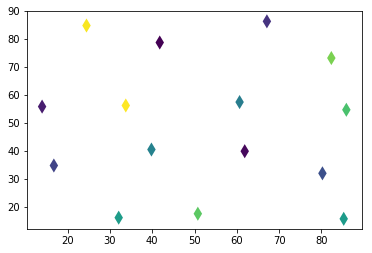

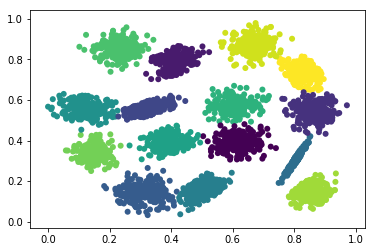

In [390]:
prediction= gmm.predict(data)
print(np.unique(prediction))
data = normalize_data(data)
# print(gmm.get_pis(), "sum is" , sum(gmm.get_pis()))
# print(gmm.get_means())
# print(gmm.get_covariances())
# print(gmm.means)
plt.scatter(gmm.means[:,0],gmm.means[:,1], c = np.random.uniform(low=0, high= 1e+5, size=len(gmm.means)), edgecolors='none', s=100, marker='d')
plt.show()
plt.scatter(data[:,0],data[:,1], c = prediction, edgecolors='none')
plt.show()

c:\python36-64\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\python36-64\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


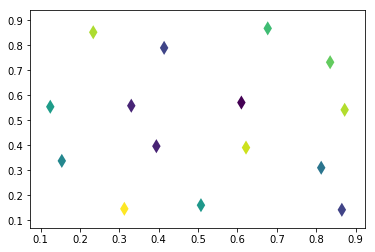

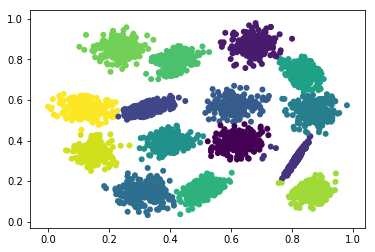

In [373]:
# np.unique(np.argmax(calc_prob(normalize_data(data), gmm.means, gmm.covariances, gmm.pis), axis=1))
kmm = KMeans(k = 15, n_iter= 100, tol=1e-6)
kmm.fit(data)
predicted, _ = kmm.predict(data)
plt.scatter(kmm.means[:,0],kmm.means[:,1], c = np.random.uniform(low=0, high= 1e+5, size=len(kmm.means)), edgecolors='none', s=100, marker='d')
plt.show()
plt.scatter(data[:,0],data[:,1], c = predicted, edgecolors='none')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as st
# import matplotlib.mlab as mlab

import math

def calc_pdf(x, mu, sigma):
    return st.norm.pdf(x, mu, sigma)
def calc_prob(data, mus, sigmas, probs):
    final_results = []
    results = []
    for dp in data:
        for mu, sigma, prob in zip(mus, sigmas, probs):
            results.append(prob * calc_pdf(dp, mu, sigma))            
        final_results.append([x / sum(results) for x in results])
        results = []
    return np.array(final_results)

size1, size2 = [0.5, 0.5]
a = np.random.normal(-2, 1, size=30)
b = np.random.normal(2, 1, size=30)
a = np.concatenate((a, b))
plt.ylim([-0.1, 1])
plt.scatter(a, np.zeros(len(a)), s=50, c='red')
mu1, mu2 = 0, 3
sigma1, sigma2 = 0.5, 0.5
x1 = np.linspace(mu1 - 3*sigma1, mu1 + 3*sigma1, 100)
x2 = np.linspace(mu2 - 3*sigma2, mu2 + 3*sigma2, 100)
plt.plot(x1,st.norm.pdf(x1, mu1, sigma1))
plt.plot(x2,st.norm.pdf(x2, mu2, sigma2))
plt.show()

for i in range(25):

    A = calc_prob(a, [mu1, mu2], [sigma1, sigma2], [size1, size2])
    left, right = A[:, 0], A[:, 1]
    mu1, mu2 = np.dot(left, a) / sum(left), np.dot(right, a) / sum(right)
    print(mu1, mu2)

    sigma1, sigma2 = np.sqrt(np.dot(left, (a-mu1)** 2) / sum(left)), np.sqrt(np.dot(right, (a-mu2)** 2) / sum(right))
    print(sigma1, sigma2)

    size1, size2 = sum(left) / len(a), sum(right) / len(a)
    print(size1, size2)

    # plt.ylim([-0.1, 1])
    plt.scatter(a, np.zeros(len(a)), s=50, c='red')
    x1 = np.linspace(mu1 - 3*sigma1, mu1 + 3*sigma1, 100)
    x2 = np.linspace(mu2 - 3*sigma2, mu2 + 3*sigma2, 100)
    plt.plot(x1,st.norm.pdf(x1, mu1, sigma1))
    plt.plot(x2,st.norm.pdf(x2, mu2, sigma2))
    plt.show()

In [348]:
X = np.arange(16).reshape(8, 1, 2)
gammas = np.arange(8).reshape(8, 1)
mu = np.array([1,1])

a = 0
for i in range(8):
    a += gammas[i] * np.outer(X[i] - mu, X[i]-mu)
a

array([[2604, 2856],
       [2856, 3136]])

In [349]:
sum = 0
tmp = X - mu
(tmp.dot(tmp.T))
# for i in range(8):
#     tmp = np.array([X[i]]- mu)    
#     sum += gammas[i] * tmp.T.dot(tmp)
# sum

ValueError: shapes (8,1,2) and (2,1,8) not aligned: 2 (dim 2) != 1 (dim 1)

In [273]:
means = np.zeros((15, 2))
for i in range(15):
    a=0
    for j in range(8):
       a+= gammas[j, i] * X[j]
    means[i] = a
means = means / np.array([gammas.sum(axis=0)]).T
means

array([[10.        , 11.        ],
       [ 9.94392523, 10.94392523],
       [ 9.88990826, 10.88990826],
       [ 9.83783784, 10.83783784],
       [ 9.78761062, 10.78761062],
       [ 9.73913043, 10.73913043],
       [ 9.69230769, 10.69230769],
       [ 9.64705882, 10.64705882],
       [ 9.60330579, 10.60330579],
       [ 9.56097561, 10.56097561],
       [ 9.52      , 10.52      ],
       [ 9.48031496, 10.48031496],
       [ 9.44186047, 10.44186047],
       [ 9.40458015, 10.40458015],
       [ 9.36842105, 10.36842105]])